# Making a synthetic model

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

# local python scripts
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import pygmt
import copy 

# for plotting
import pvxarray
import matplotlib.pyplot as plt
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_slice
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# hvplot.extension('bokeh', 'matplotlib', 'plotly')
import panel.widgets as pnw
import panel as pn

pn.extension(comms="vscode")

import os

PROJ: proj_create_from_database: Cannot find proj.db


# Turn plotting on or off

In [2]:
plotting = True

# Set region and parameters

In [3]:
# set grid parameters
spacing = 1e3
registration = "g"

inversion_region = [0e3, 80e3, 0e3, 60e3]

buffer_region = utils.alter_region(
    inversion_region,
    buffer=20e3,
)[1]

outer_region = utils.alter_region(
    buffer_region,
    zoom=-spacing,
)[0]

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)
print("outer region = ", outer_region)

inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-20000, 100000, -20000, 80000]
outer region =  [-21000.0, 101000.0, -21000.0, 81000.0]


# Create synthetic layers

## Synthetic model
Here we'll construct a simple synthetic model

### upper layer

returning grid with new region and/or registration, same spacing


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


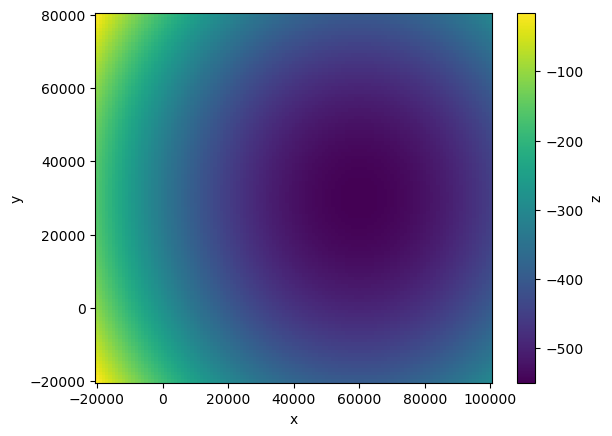

In [4]:
layer1 = synth.synthetic_topography_upper(
    spacing,
    outer_region,
    low=-550,
    high=0,
    registration=registration,
)

layer1 = fetch.resample_grid(
    layer1, spacing=spacing, region=buffer_region, registration=registration
)

utils.get_grid_info(layer1)
layer1.plot()

In [5]:
# # create grid of coordinates
# coords = vd.grid_coordinates(
#     region=outer_region,
#     spacing=spacing,
#     pixel_register=False,
# )

# # create xarray dataarray from coordinates with a constant value of 0m
# layer1 = vd.make_xarray_grid(
#     coords, np.ones_like(coords[0]) * 0, data_names="z", dims=("y", "x")
# ).z

# layer1 = fetch.resample_grid(
#     layer1, spacing=spacing, region=buffer_region, registration=registration
# )

# utils.get_grid_info(layer1)

### Layer2

returning grid with new region and/or registration, same spacing


(1000.0,
 [-20000.0, 100000.0, -20000.0, 80000.0],
 -850.314697266,
 -393.246643066,
 'g')

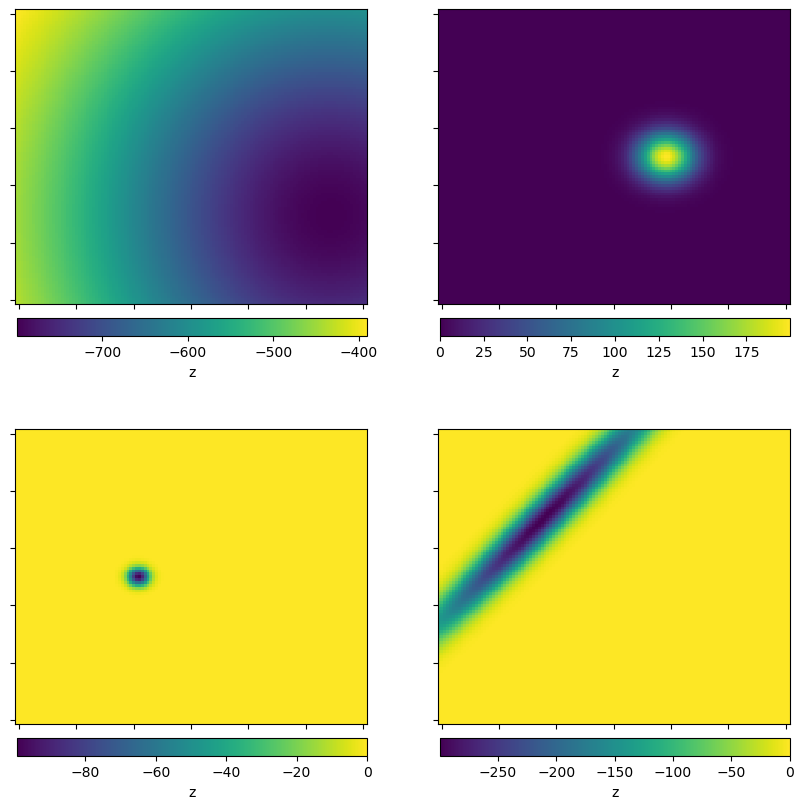

In [6]:
layer2 = synth.synthetic_topography_simple(
    spacing,
    outer_region,
    plot_individuals=True,
    registration=registration,
)

layer2 = fetch.resample_grid(
    layer2, spacing=spacing, region=buffer_region, registration=registration
)

utils.get_grid_info(layer2)

### base layer

returning grid with new region and/or registration, same spacing


(1000.0,
 [-20000.0, 100000.0, -20000.0, 80000.0],
 -4216.69628906,
 -3573.74169922,
 'g')

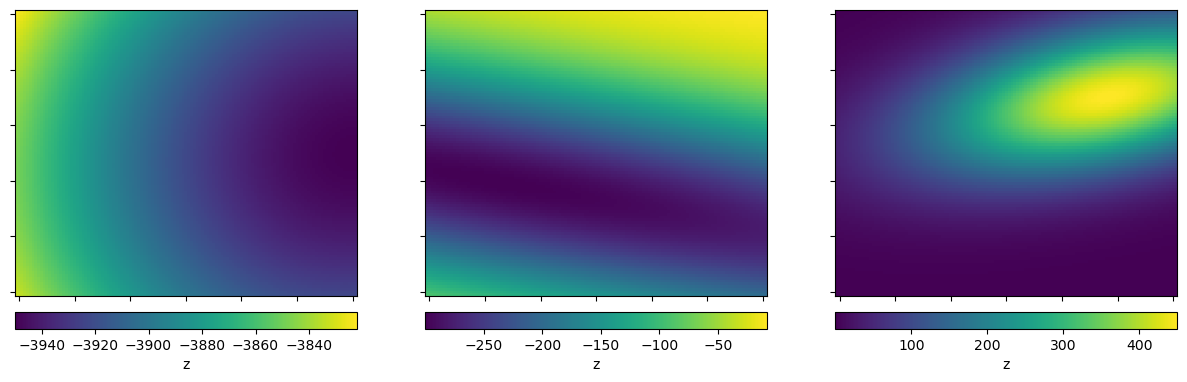

In [7]:
layer3 = synth.synthetic_topography_regional(
    spacing,
    outer_region,
    plot_individuals=True,
    registration=registration,
    scale=3,
)

layer3 = fetch.resample_grid(
    layer3, spacing=spacing, region=buffer_region, registration=registration
)

utils.get_grid_info(layer3)

returning original grid
returning original grid
returning original grid


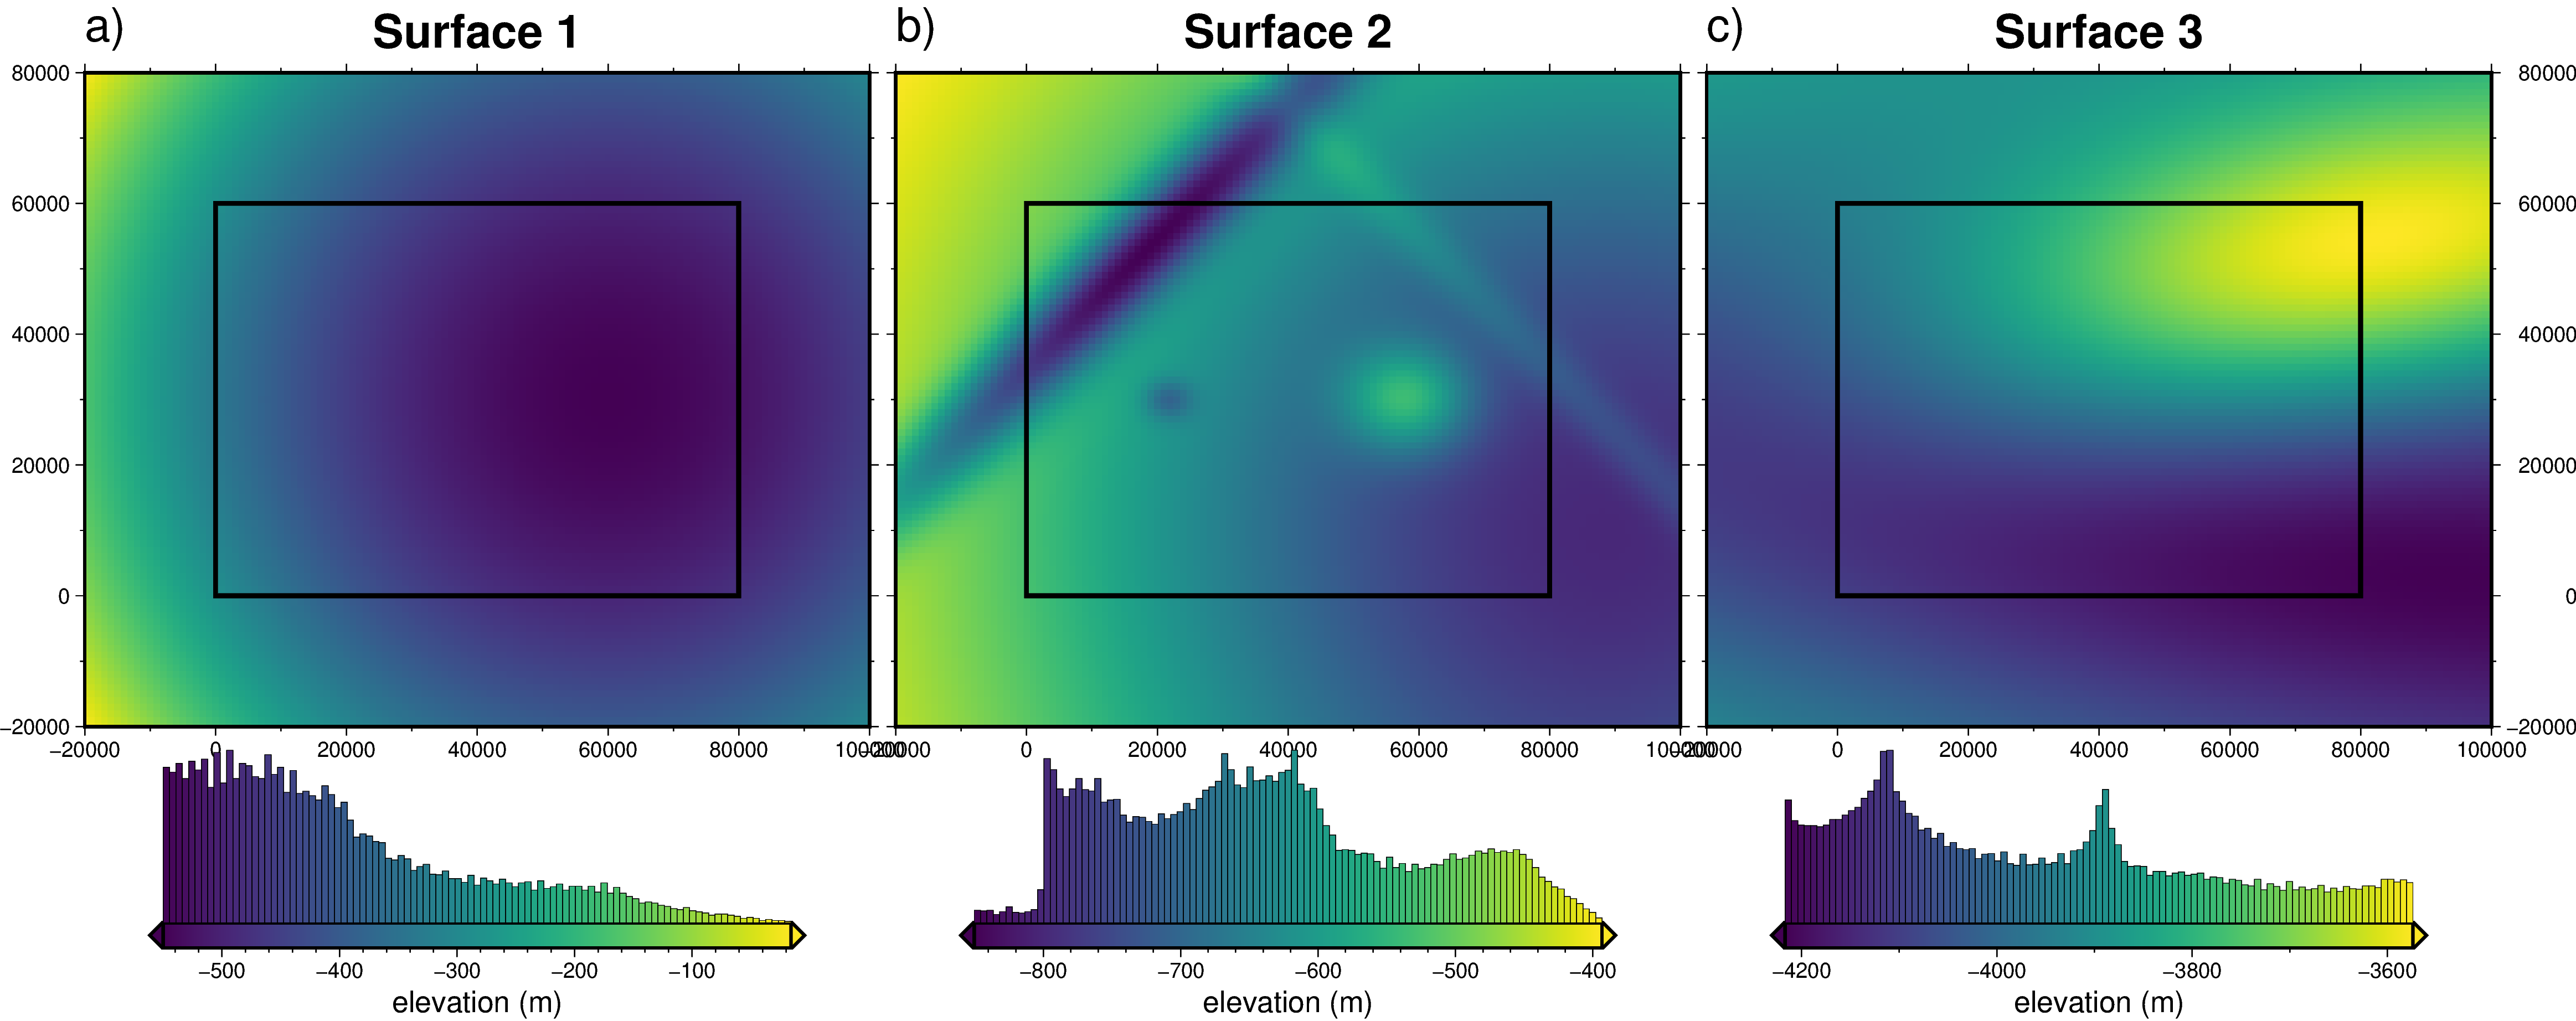

In [8]:
if plotting is True:
    fig = maps.plot_grd(
        layer1,
        fig_height=10,
        title="Surface 1",
        hist=True,
        cbar_yoffset=3,
        grd2_cpt=True,
        cbar_label="elevation (m)",
        frame=["nSWe", "xaf10000", "yaf10000"],
        show_region=inversion_region,
    )

    fig.text(
        position='TL',
        text = "a)",
        fill = 'white',
        font = '20p,Helvetica,black',
        offset = 'j0/-1',
        clearance = '+tO',
        no_clip=True,
        )

    fig = maps.plot_grd(
        layer2,
        fig_height=10,
        title="Surface 2",
        hist=True,
        cbar_yoffset=3,
        grd2_cpt=True,
        cbar_label="elevation (m)",
        frame=["nSwe", "xaf10000", "yaf10000"],
        show_region=inversion_region,
        fig=fig,
        origin_shift="xshift",
    )

    fig.text(
        position='TL',
        text = "b)",
        fill = 'white',
        font = '20p,Helvetica,black',
        offset = 'j0/-1',
        clearance = '+tO',
        no_clip=True,
        )

    fig = maps.plot_grd(
        layer3,
        fig_height=10,
        title="Surface 3",
        hist=True,
        cbar_yoffset=3,
        grd2_cpt=True,
        cbar_label="elevation (m)",
        frame=["nSwE", "xaf10000", "yaf10000"],
        show_region=inversion_region,
        fig=fig,
        origin_shift="xshift",
    )

    fig.text(
        position='TL',
        text = 'c)',
        fill = 'white',
        font = '20p,Helvetica,black',
        offset = 'j0/-1',
        clearance = '+tO',
        no_clip=True,
        )

    fig.show()

### visualize in 3d

In [9]:
if plotting is True:
    fig = make_subplots(
        rows=1,
        cols=3,
        specs=[
            [
                {"is_3d": True},
                {"is_3d": True},
                {"is_3d": True},
            ]
        ],
        subplot_titles=[
            "Surface 1",
            "Surface 2",
            "Surface 3",
        ],
    )

    fig.add_trace(go.Surface(z=layer1.values, colorbar_x=-.1), 1, 1)
    fig.add_trace(go.Surface(z=layer2.values, colorbar_x=.25), 1, 2)
    fig.add_trace(go.Surface(z=layer3.values, colorbar_x=1), 1, 3)

    fig.show()

### save to .zarr files

In [10]:
# save to zarr files
output = layer1.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_layer1_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = layer2.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_layer2_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = layer3.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_layer3_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

### load .zarr files

In [11]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3_simple.zarr").z

## Observed gravity
use this synthetic model to create a synthethic gravity survey. This synthetic gravity anomaly will have both regional and short-wavelength signals, from the base layer and bathymetry layer, respectively.

### make a dictionary of properties

In [12]:
layers = {
    "layer1": {
        "spacing": spacing,
        "rho": 1030,  # 0,
        "grid": layer1,
    },
    "layer2": {
        "spacing": spacing,
        "rho": 2300,  # 2300-1030,
        "grid": layer2,
    },
    "layer3": {
        "spacing": spacing,
        "rho": 2670,  # 2670-2300,
        "grid": layer3,
    },
}

# resample layer grids to match
for k, v in layers.items():
    print(f"\n{'':*<20}Resampling {k} layer {'':*>20}")
    v["grid"] = fetch.resample_grid(
        v["grid"],
        spacing=v["spacing"],
        region=buffer_region,
        registration=registration,
        verbose="q",
    )
    print(utils.get_grid_info(v["grid"]))

# Low resolution (10km) version for vizualization
layers_lowres = copy.deepcopy(layers)

for k, v in layers_lowres.items():
    v["grid"] = fetch.resample_grid(
        v["grid"],
        spacing=10e3,
        region=buffer_region,
        registration=registration,
        verbose="q",
    )


********************Resampling layer1 layer ********************
returning original grid
(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -550.0, -15.7280073166, 'g')

********************Resampling layer2 layer ********************
returning original grid
(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -850.314697266, -393.246643066, 'g')

********************Resampling layer3 layer ********************
returning original grid
(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -4216.69628906, -3573.74169922, 'g')
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling


### forward gravity of the model

#### make a prism model

In [20]:
inv.grids_to_prism_layers(
    layers,
    registration="g",
    # lowest_bottom=-5e3,
)

inv.grids_to_prism_layers(
    layers_lowres,
    registration="g",
    # lowest_bottom=-5e3,
)

********** layer3 top: -3968m and bottom: -4216m **********
********** layer2 top: -642m and bottom: -3968m **********

********** layer1 top: -401m and bottom: -642m **********



c:\Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\notebooks\..\RIS_gravity_inversion\inversion.py:48: UserWarning:

        tops equal to bottoms for these prisms (thickness of 0).
        



********** layer3 top: -3967m and bottom: -4214m **********
********** layer2 top: -635m and bottom: -3967m **********

********** layer1 top: -384m and bottom: -635m **********



In [18]:
if plotting is True:
    fig = go.Figure(
        data=[
            go.Surface(
                z=layer1.values,
                colorscale="Blues",
                opacity=1,#0.8,
                colorbar_x=.8,
            ),
            go.Surface(
                z=layer2.values,
                colorscale="Greens",
                opacity=0.9,
                colorbar_x=.95,
            ),
            go.Surface(
                z=layer3.values,
                colorscale="Electric",
                colorbar_x=1.1,
            ),
        ],
    )

    # fig.update_traces(
    #     contours_z=dict(
    #         show=True,
    #         usecolormap=True,
    #         highlightcolor="limegreen",
    #         project_z=True,
    #     ),
    # )

    camera = dict(eye=dict(x=1, y=1, z=1))

    fig.update_layout(
        title="3 Layer Model",
        # scene_camera=camera,
        scene_aspectmode='manual',
        scene_aspectratio=dict(x=1, y=1, z=1)
    )

    fig.show()

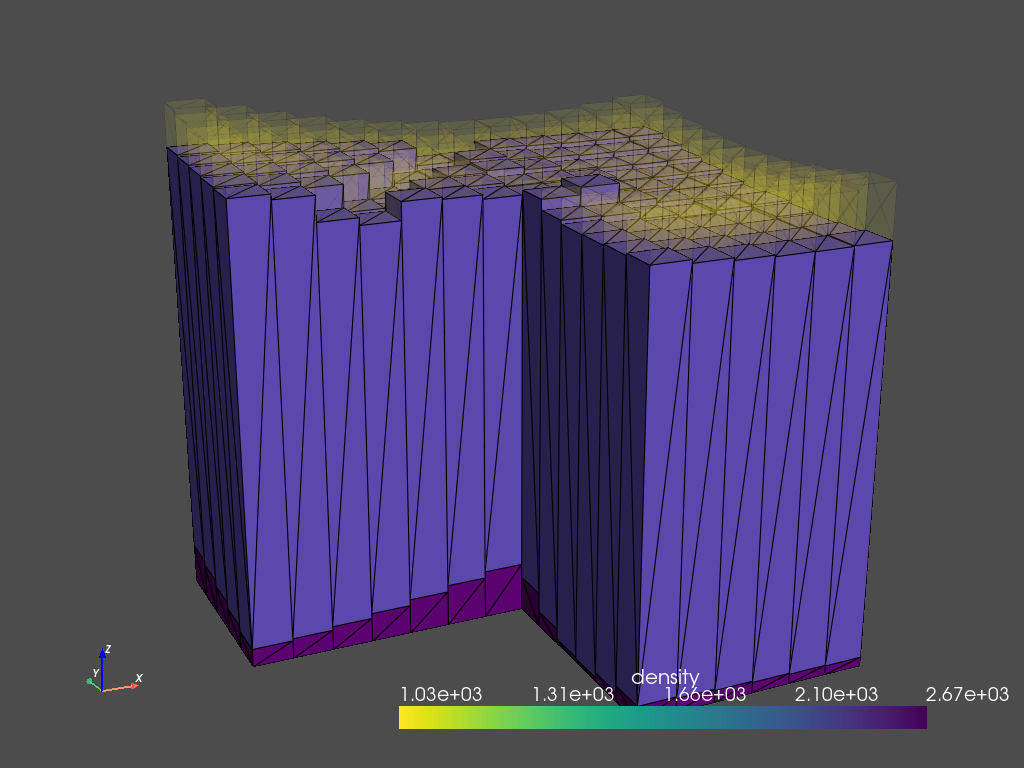

In [22]:
if plotting is True:
    plots.plot_prism_layers(
        layers_lowres,
        plot_type='3D',
        # region=utils.alter_region(inversion_region, zoom=0e3,)[0],
        color_by='density',
        # color_by="thickness",
        # color_by='constant',
        flip_scalars=True,
        # clip_box=False,
        # log_scale=False,
        # layers_for_3d=["layer2", "layer3"],
        show_edges=True,
        # smooth_shading=True,
        # style='wireframe',
        opacity=[0.05, 1, 1],
        zscale=30,
        backend='static',
    #     backend='panel',
        # backend='pythreejs',
    #     backend='ipygany',
    #     backend='ipyvtklink',
    )

### Forward gravity of full region

make pandas dataframe of locations to calculate gravity

In [23]:
synthetic_grav_spacing = spacing
# synthetic_grav_spacing = 10e3
# create lists of coordinates
(x, y) = vd.grid_coordinates(
    region=buffer_region,
    spacing=synthetic_grav_spacing,
    pixel_register=False,
)

# grid the coordinates with a constant height of 1km
observations = vd.make_xarray_grid(
    (x, y),
    np.ones_like(x) * 1e3,
    data_names="z",
    dims=("y", "x"),
).z

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

df = vd.grid_to_table(observations)

(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], 1000.0, 1000.0, 'g')


#### calculate forward gravity of model

In [24]:
synthetic_forward = inv.forward_grav_layers(
    layers,
    df,
    exclude_layers=None,
    progressbar=True,
    parallel=True,
)

  0%|          | 0/12221 [00:00<?, ?it/s]

12221 prisms in layer1 layer
finished layer1 layer


  0%|          | 0/12221 [00:00<?, ?it/s]

12221 prisms in layer2 layer
finished layer2 layer


  0%|          | 0/12221 [00:00<?, ?it/s]

12221 prisms in layer3 layer
finished layer3 layer


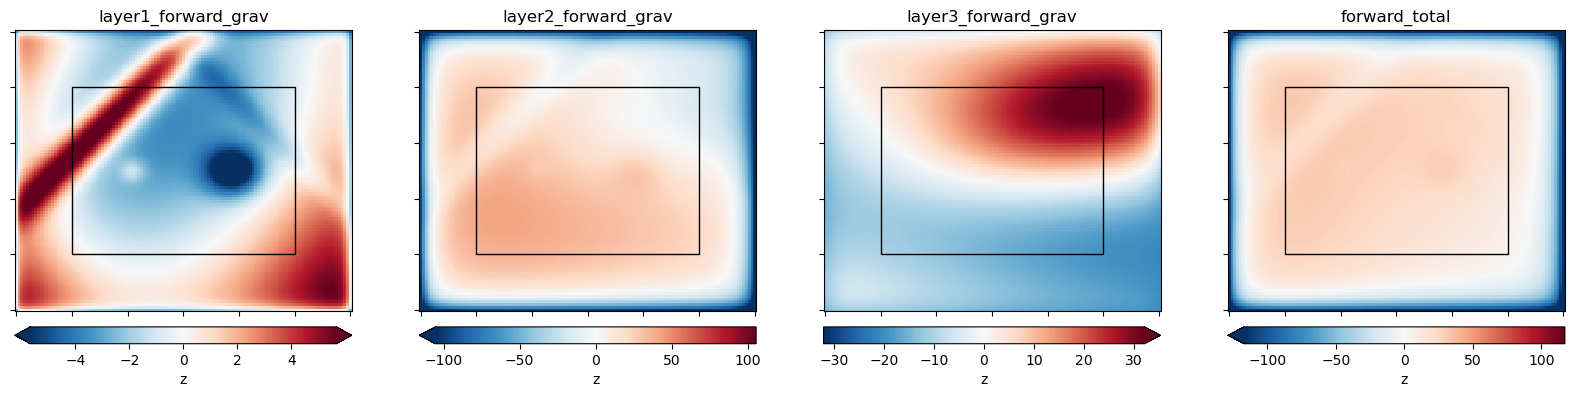

In [25]:
# with buffer region
forward_grids = plots.forward_grav_plotting(
    synthetic_forward,
    region=buffer_region,
    grav_spacing=synthetic_grav_spacing,
    inversion_region=inversion_region,
)

### Forward gravity of just inversion area

make pandas dataframe of locations to calculate gravity

In [26]:
synthetic_grav_spacing = spacing
# synthetic_grav_spacing = 10e3
# create lists of coordinates
(x, y) = vd.grid_coordinates(
    region=inversion_region,
    spacing=synthetic_grav_spacing,
    pixel_register=False,
)

# grid the coordinates with a constant height of 1km
observations = vd.make_xarray_grid(
    (x, y),
    np.ones_like(x) * 1e3,
    data_names="z",
    dims=("y", "x"),
).z

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

df = vd.grid_to_table(observations)

(1000.0, [0.0, 80000.0, 0.0, 60000.0], 1000.0, 1000.0, 'g')


#### calculate forward gravity of model

In [27]:
synthetic_forward = inv.forward_grav_layers(
    layers,
    df,
    exclude_layers=None,
    progressbar=True,
    parallel=True,
)

  0%|          | 0/4941 [00:00<?, ?it/s]

12221 prisms in layer1 layer
finished layer1 layer


  0%|          | 0/4941 [00:00<?, ?it/s]

12221 prisms in layer2 layer
finished layer2 layer


  0%|          | 0/4941 [00:00<?, ?it/s]

12221 prisms in layer3 layer
finished layer3 layer


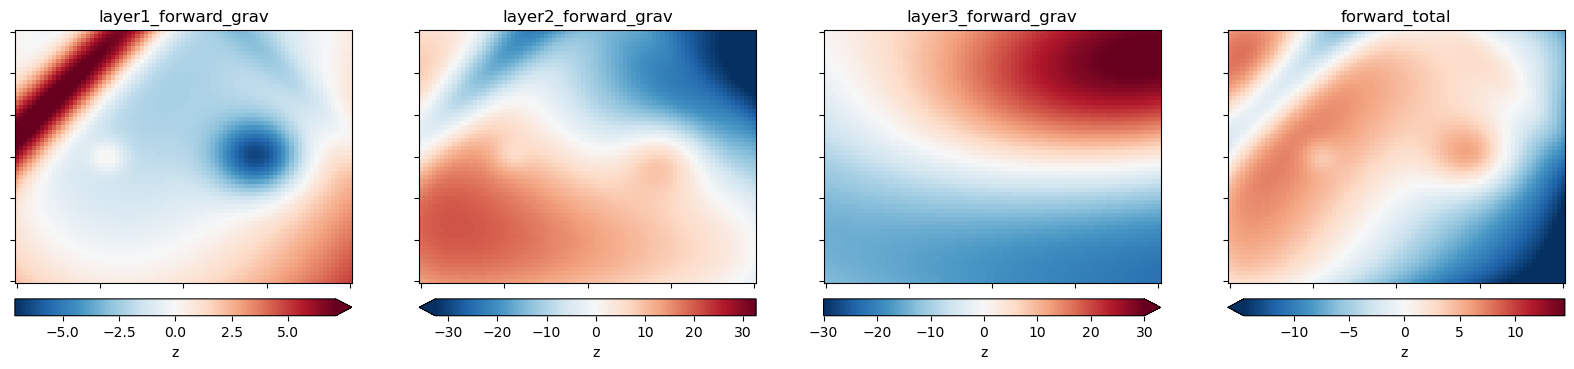

In [28]:
forward_grids = plots.forward_grav_plotting(
    synthetic_forward,
    region=inversion_region,
    grav_spacing=synthetic_grav_spacing,
)

In [29]:
pd.options.plotting.backend = "holoviews"
# synthetic_forward.drop(['x','y','z'], axis=1).plot(kind='hist', alpha=0.5, bins=50)
synthetic_forward.drop(["x", "y", "z"], axis=1).plot(
    kind="hist", subplots=True, width=300, bins=50
).cols(2)

:NdLayout   [Default]
   :Histogram   [forward_total]   (forward_total_count)

In [30]:
# rename dataarray variables
for k, v in forward_grids.items():
    forward_grids[k] = v.rename(k)

# combine into a dataset
forward_grav = xr.merge(list(forward_grids.values()))

# save to a .zarr file
forward_grav.to_zarr(
    "../synthetic_data/synthetic_forward_grav_simple.zarr",
    mode="w",
)

# load zarr file
forward_grav = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple.zarr")
forward_grav

<xarray.Dataset>
Dimensions:              (y: 61, x: 81)
Coordinates:
  * x                    (x) float64 0.0 1e+03 2e+03 ... 7.8e+04 7.9e+04 8e+04
  * y                    (y) float64 0.0 1e+03 2e+03 ... 5.8e+04 5.9e+04 6e+04
Data variables:
    forward_total        (y, x) float32 dask.array<chunksize=(61, 81), meta=np.ndarray>
    layer1_forward_grav  (y, x) float32 dask.array<chunksize=(61, 81), meta=np.ndarray>
    layer2_forward_grav  (y, x) float32 dask.array<chunksize=(61, 81), meta=np.ndarray>
    layer3_forward_grav  (y, x) float32 dask.array<chunksize=(61, 81), meta=np.ndarray>
Attributes:
    actual_range:  [-6.46823787689209, 7.852171421051025]
    long_name:     z

### add noise

In [31]:
synthetic_forward["grav_noisy"] = synth.contaminate(
    synthetic_forward.forward_total,
    stddev=0.02,
    percent=True,
    seed=0,
)
synthetic_forward.describe()

y             x       z  layer1_forward_grav  \
count   4941.000000   4941.000000  4941.0         4.941000e+03   
mean   30000.000000  40000.000000  1000.0         1.472568e-15   
std    17608.598838  23383.270257     0.0         2.591260e+00   
min        0.000000      0.000000  1000.0        -6.468238e+00   
25%    15000.000000  20000.000000  1000.0        -1.846357e+00   
50%    30000.000000  40000.000000  1000.0        -3.725356e-01   
75%    45000.000000  60000.000000  1000.0         1.080873e+00   
max    60000.000000  80000.000000  1000.0         7.852172e+00   

       layer2_forward_grav  layer3_forward_grav  forward_total    grav_noisy  
count         4.941000e+03         4.941000e+03   4.941000e+03  4.941000e+03  
mean          1.472568e-15         1.472568e-15   4.417703e-15  3.865491e-15  
std           1.416915e+01         1.515993e+01   5.667154e+00  5.680438e+00  
min          -3.790771e+01        -2.227205e+01  -1.994929e+01 -2.040709e+01  
25%          -1.045981e+01        -1.418657e+01  -3.114050e+00 -3.113396e+00  
50%           3.072194e+00        -1.833808e+00   1.642863e+00  1.629292e+00  
75%           1.101175e+01         1.155402e+01   4.254961e+00  4.296102e+00  
max           2.068748e+01         3.120933e+01   7.961406e+00  8.654768e+00

compare with and without noise

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


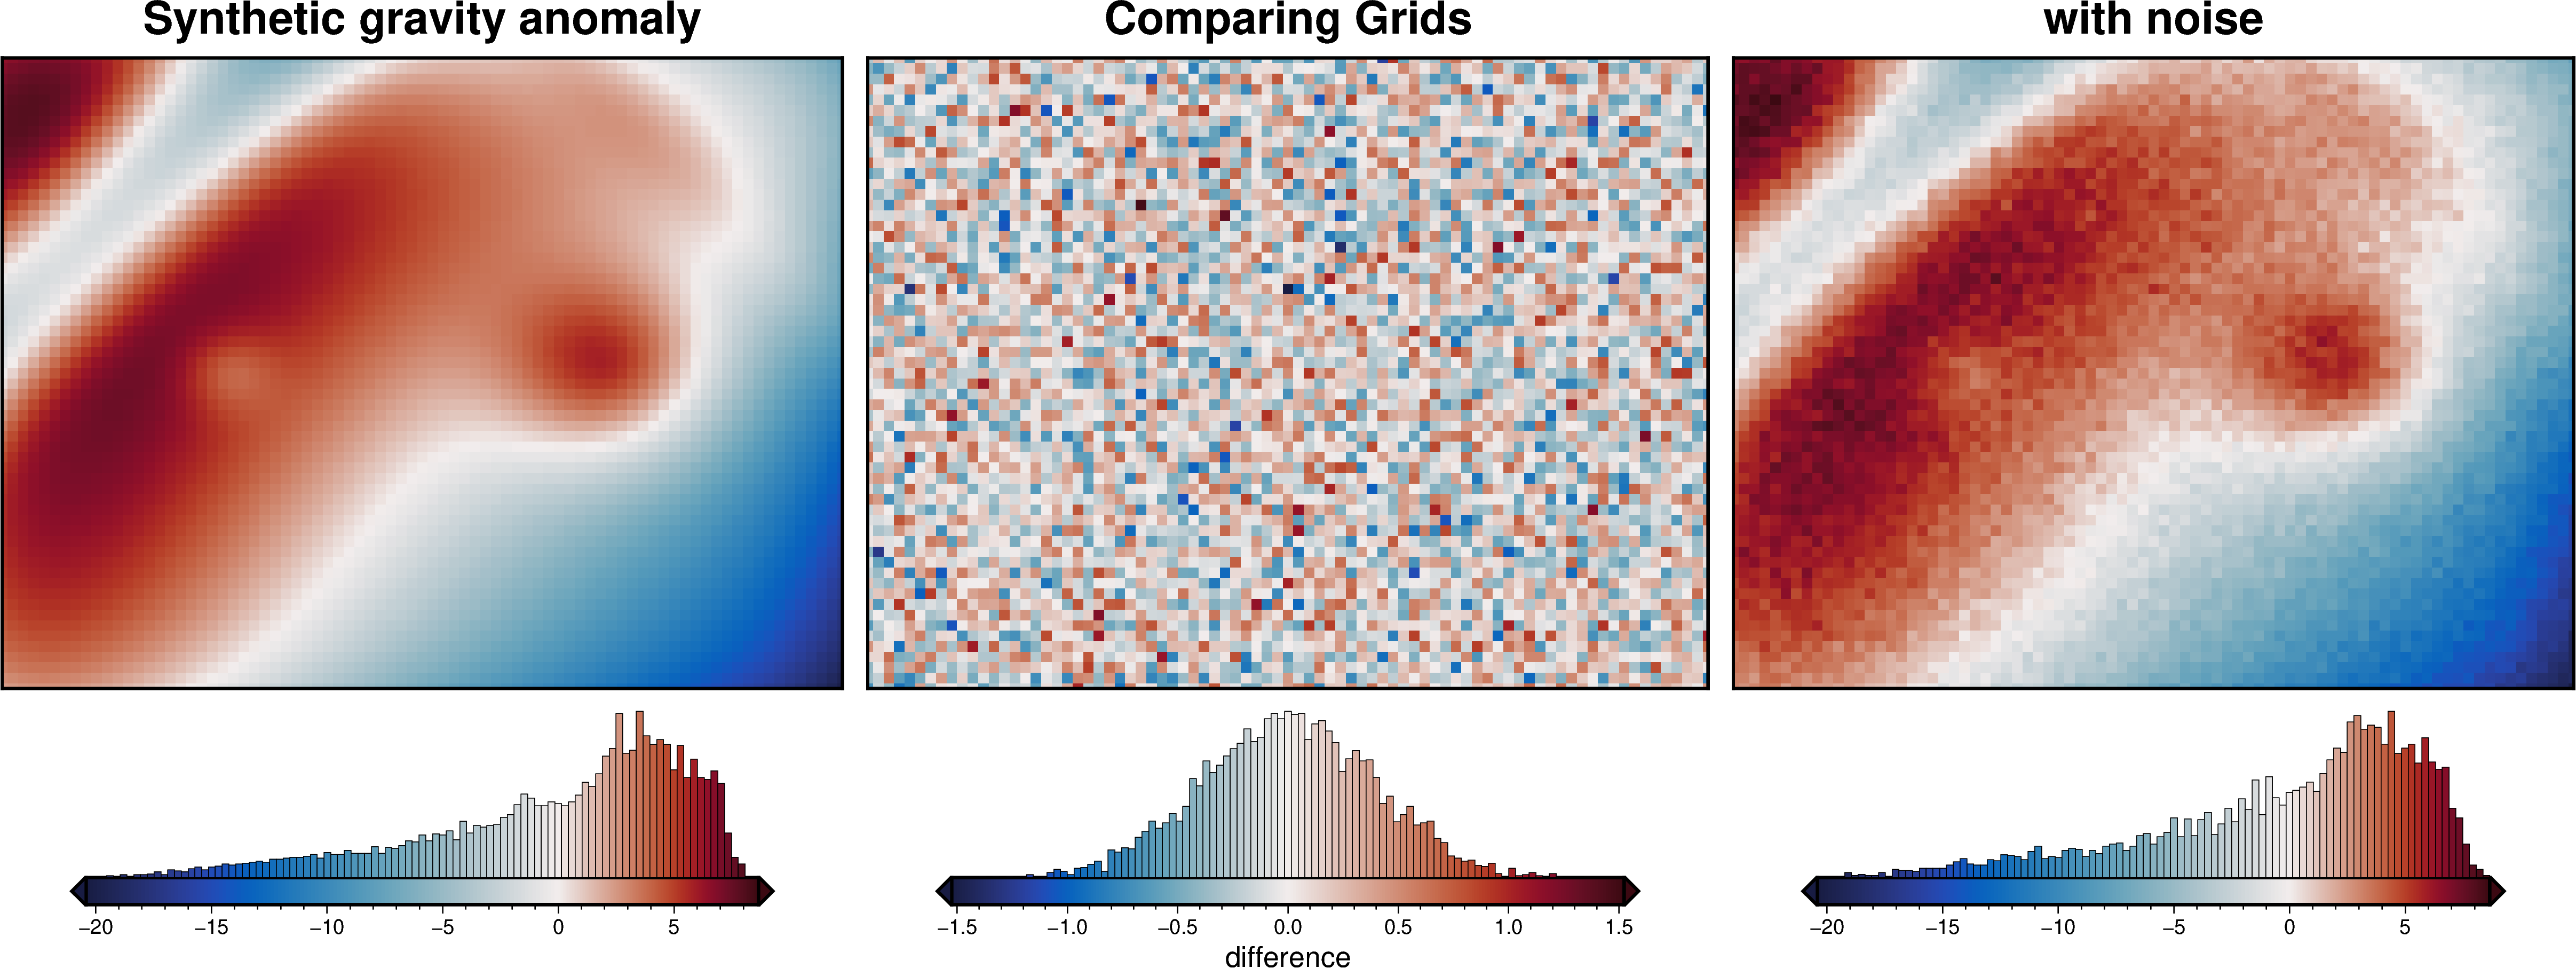

In [32]:
if plotting is True:
    grav_noise_free = synthetic_forward.set_index(["y", "x"]).to_xarray().forward_total
    grav_noisy = synthetic_forward.set_index(["y", "x"]).to_xarray().grav_noisy

    grids = utils.grd_compare(
        grav_noise_free,
        grav_noisy,
        plot=True,
        plot_type="pygmt",
    #     cmap="RdBu_r",
        cmap="balance+h0",
        grid1_name="Synthetic gravity anomaly",
        grid2_name="with noise",
        inset=False,
        hist=True
    )

### create observation points

In [33]:
obs_grav_spacing = 2e3

# regular grid
coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=obs_grav_spacing,
    pixel_register=False,
)

# turn coordinates into dataarray
grav = vd.make_xarray_grid(
    coords, data=np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
)
# turn dataarray into dataframe
df = vd.grid_to_table(grav)
df


y        x       z
0         0.0      0.0  1000.0
1         0.0   2000.0  1000.0
2         0.0   4000.0  1000.0
3         0.0   6000.0  1000.0
4         0.0   8000.0  1000.0
...       ...      ...     ...
1266  60000.0  72000.0  1000.0
1267  60000.0  74000.0  1000.0
1268  60000.0  76000.0  1000.0
1269  60000.0  78000.0  1000.0
1270  60000.0  80000.0  1000.0

[1271 rows x 3 columns]

### sample grid

In [34]:
# grid the synthetic gravity data
synthetic_gravity = synthetic_forward.set_index(["y", "x"]).to_xarray().grav_noisy

# sample the noisy data at the observation points
grav = profile.sample_grids(df, synthetic_gravity, "Gobs")
grav

y        x       z      Gobs
0         0.0      0.0  1000.0  3.016510
1         0.0   2000.0  1000.0  3.013214
2         0.0   4000.0  1000.0  3.445214
3         0.0   6000.0  1000.0  2.981278
4         0.0   8000.0  1000.0  2.329484
...       ...      ...     ...       ...
1266  60000.0  72000.0  1000.0 -3.695793
1267  60000.0  74000.0  1000.0 -5.013673
1268  60000.0  76000.0  1000.0 -5.508921
1269  60000.0  78000.0  1000.0 -6.717003
1270  60000.0  80000.0  1000.0 -7.701635

[1271 rows x 4 columns]

grid the sampled points

In [35]:
Gobs = pygmt.surface(
    data=grav[["x", "y", "Gobs"]],
    region=inversion_region,
    spacing=obs_grav_spacing,
    registration=registration,
    T=0.25,
    verbose="q",
)

plot synthetic gravity anomaly

returning grid with new region and/or registration, same spacing
returning grid with new region and/or registration, same spacing


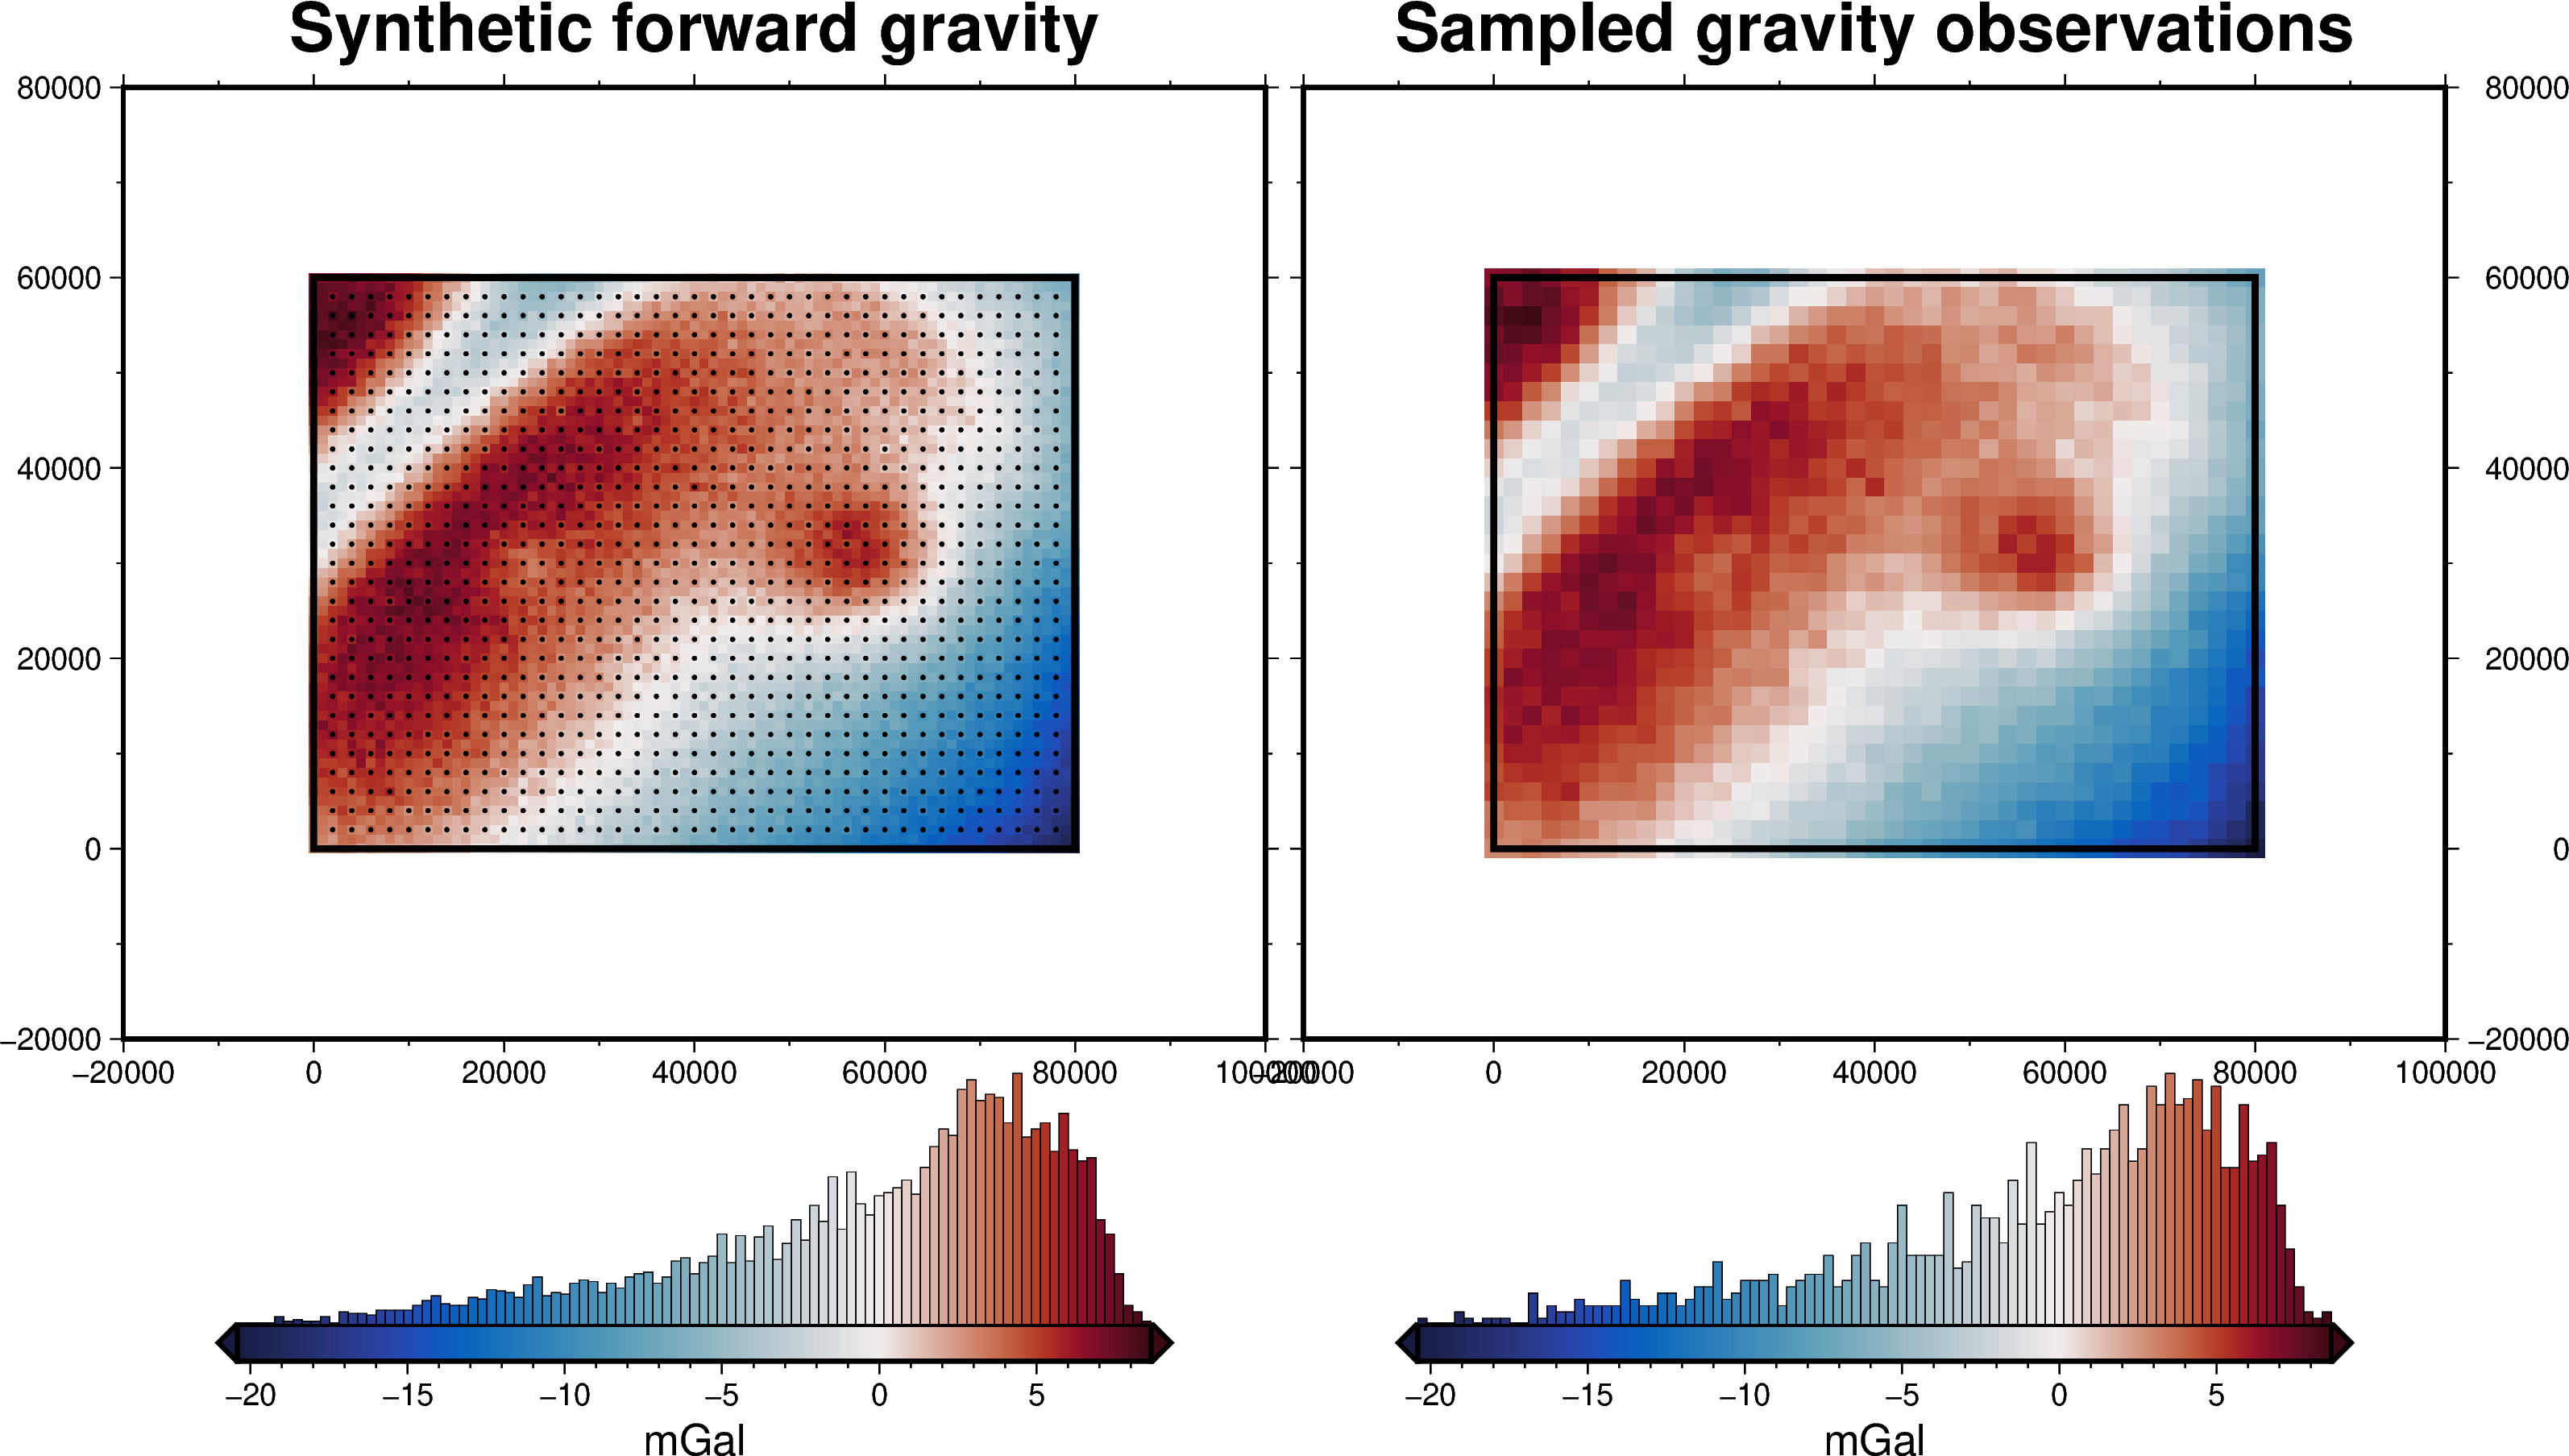

In [36]:
if plotting is True:
    # plot the synthetic gravity anomaly grid
    fig = maps.plot_grd(
        synthetic_gravity,
        region=buffer_region,
        fig_height=10,
        cmap="balance+h0",
        title="Synthetic forward gravity",
        cbar_label="mGal",
        frame=["nSWe", "xaf10000", "yaf10000"],
        show_region=inversion_region,
        hist=True,
        cbar_yoffset=3,
        grd2_cpt=True,
    )

    # plot observation points
    fig.plot(grav[["x", "y"]], style="c.05c", color="black")

    # plot the synthetic observed gravity grid
    fig = maps.plot_grd(
        Gobs,
        region=buffer_region,
        fig_height=10,
        cmap="balance+h0",
        title="Sampled gravity observations",
        cbar_label="mGal",
        frame=["nSwE", "xaf10000", "yaf10000"],
        show_region=inversion_region,
        hist=True,
        cbar_yoffset=3,
        grd2_cpt=True,
        fig=fig,
        origin_shift="xshift",
    )

    fig.show()

## save to a csv
re-format the dataframe

In [37]:
grav.rename(
    columns={
        "z": "ellipsoidal_elevation",
        "Gobs": "free_air_anomaly",
    },
    inplace=True,
)
grav

y        x  ellipsoidal_elevation  free_air_anomaly
0         0.0      0.0                 1000.0          3.016510
1         0.0   2000.0                 1000.0          3.013214
2         0.0   4000.0                 1000.0          3.445214
3         0.0   6000.0                 1000.0          2.981278
4         0.0   8000.0                 1000.0          2.329484
...       ...      ...                    ...               ...
1266  60000.0  72000.0                 1000.0         -3.695793
1267  60000.0  74000.0                 1000.0         -5.013673
1268  60000.0  76000.0                 1000.0         -5.508921
1269  60000.0  78000.0                 1000.0         -6.717003
1270  60000.0  80000.0                 1000.0         -7.701635

[1271 rows x 4 columns]

In [38]:
grav["lat"] = np.nan
grav["lon"] = np.nan
grav["station_ID"] = np.nan
grav["geoidal_elevation"] = np.nan
grav["elevation_error"] = np.nan
grav["observed_gravity"] = np.nan
grav["observed_gravity_error"] = np.nan
grav["gravity_disturbance"] = np.nan
grav["gravity_disturbance_error"] = np.nan
grav["free_air_anomaly_error"] = np.nan

In [39]:
grav = grav[
    [
        "x",
        "y",
        "lat",
        "lon",
        "station_ID",
        "ellipsoidal_elevation",
        "geoidal_elevation",
        "elevation_error",
        "observed_gravity",
        "observed_gravity_error",
        "gravity_disturbance",
        "gravity_disturbance_error",
        "free_air_anomaly",
        "free_air_anomaly_error",
    ]
]
grav

x        y  lat  lon  station_ID  ellipsoidal_elevation  \
0         0.0      0.0  NaN  NaN         NaN                 1000.0   
1      2000.0      0.0  NaN  NaN         NaN                 1000.0   
2      4000.0      0.0  NaN  NaN         NaN                 1000.0   
3      6000.0      0.0  NaN  NaN         NaN                 1000.0   
4      8000.0      0.0  NaN  NaN         NaN                 1000.0   
...       ...      ...  ...  ...         ...                    ...   
1266  72000.0  60000.0  NaN  NaN         NaN                 1000.0   
1267  74000.0  60000.0  NaN  NaN         NaN                 1000.0   
1268  76000.0  60000.0  NaN  NaN         NaN                 1000.0   
1269  78000.0  60000.0  NaN  NaN         NaN                 1000.0   
1270  80000.0  60000.0  NaN  NaN         NaN                 1000.0   

      geoidal_elevation  elevation_error  observed_gravity  \
0                   NaN              NaN               NaN   
1                   NaN              NaN               NaN   
2                   NaN              NaN               NaN   
3                   NaN              NaN               NaN   
4                   NaN              NaN               NaN   
...                 ...              ...               ...   
1266                NaN              NaN               NaN   
1267                NaN              NaN               NaN   
1268                NaN              NaN               NaN   
1269                NaN              NaN               NaN   
1270                NaN              NaN               NaN   

      observed_gravity_error  gravity_disturbance  gravity_disturbance_error  \
0                        NaN                  NaN                        NaN   
1                        NaN                  NaN                        NaN   
2                        NaN                  NaN                        NaN   
3                        NaN                  NaN                        NaN   
4                        NaN                  NaN                        NaN   
...                      ...                  ...                        ...   
1266                     NaN                  NaN                        NaN   
1267                     NaN                  NaN                        NaN   
1268                     NaN                  NaN                        NaN   
1269                     NaN                  NaN                        NaN   
1270                     NaN                  NaN                        NaN   

      free_air_anomaly  free_air_anomaly_error  
0             3.016510                     NaN  
1             3.013214                     NaN  
2             3.445214                     NaN  
3             2.981278                     NaN  
4             2.329484                     NaN  
...                ...                     ...  
1266         -3.695793                     NaN  
1267         -5.013673                     NaN  
1268         -5.508921                     NaN  
1269         -6.717003                     NaN  
1270         -7.701635                     NaN  

[1271 rows x 14 columns]

In [40]:
grav.to_csv(
    "../synthetic_data/synthetic_gravity_simple.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

## create random constraint points

In [41]:
coords = vd.scatter_points(region=inversion_region, size=30, random_state=1)
constraint_points = pd.DataFrame(data={"x": coords[0], "y": coords[1]})

In [42]:
constraint_points.to_csv(
    "../synthetic_data/synthetic_constraints_simple.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

## create starting Layer2

grid spacings don't match, using smaller spacing (1000.0m).
returning original grid
Warning, requested spacing (1000.0) is smaller than the original  (2000.0).


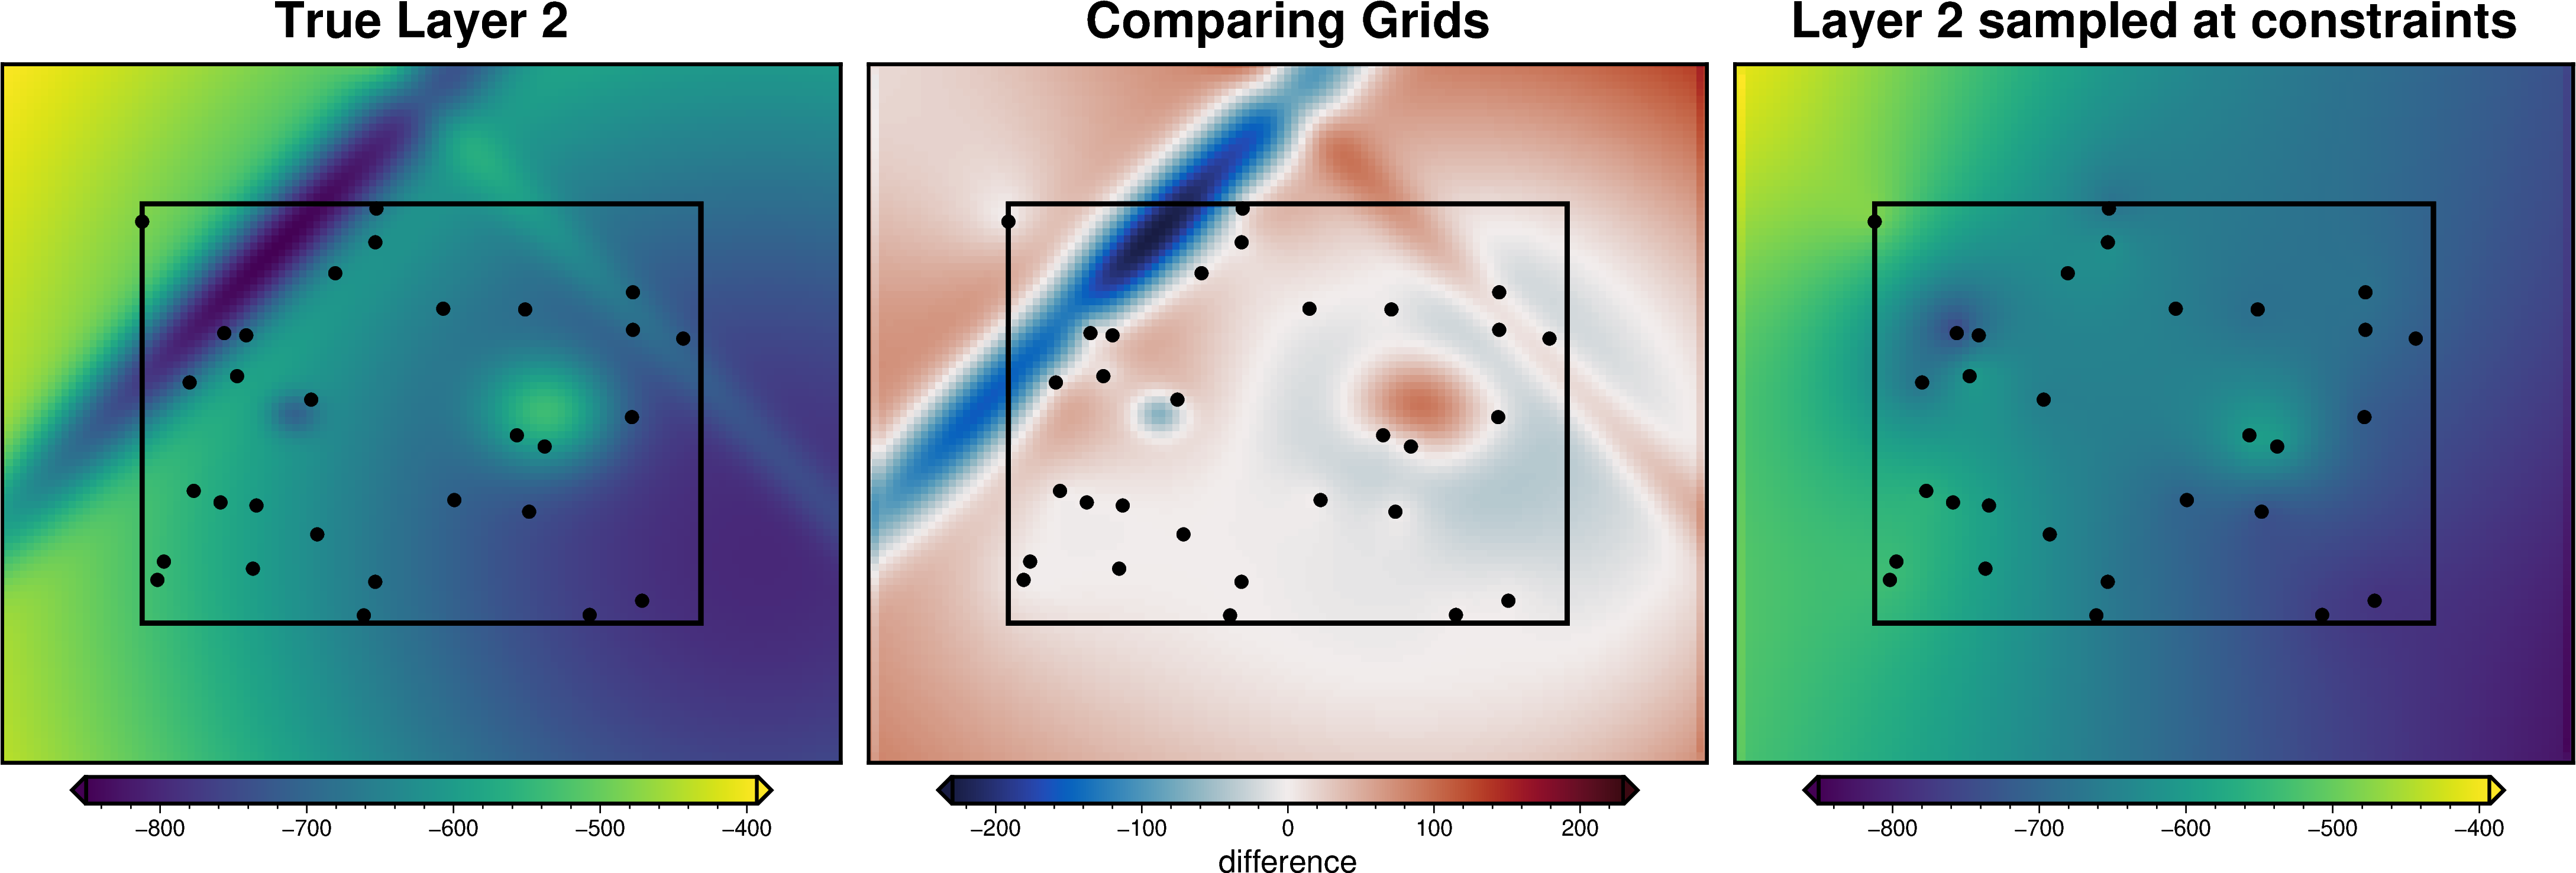

In [43]:
if plotting is True:
    df = constraint_points.copy()
    df = profile.sample_grids(df, layer2, "z")
    starting_layer2 = pygmt.surface(
        data=df,
        region=buffer_region,
        spacing=obs_grav_spacing,
        registration=registration,
        T=0.35,
        verbose="q",
    )

    # compare starting and actual layer2 grids
    grids = utils.grd_compare(
        layer2,
        starting_layer2,
        plot=True,
        plot_type="pygmt",
        grid1_name="True Layer 2",
        grid2_name="Layer 2 sampled at constraints",
        points=df,
        show_region=inversion_region,
        inset=False,
    )

## save inputs as .zarr files

In [44]:
output = starting_layer2.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)